In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Requirement 3

In [8]:
# Non stationary env for tarification pb
class NonStationaryPricingEnvironment:
    def __init__(self, num_days, price_levels, intervals):
        self.num_days = num_days
        self.price_levels = price_levels
        self.intervals = intervals
        self.demand_curves = self._generate_demand_curves()
        self.noise_level = 5  #Noise level

    def _generate_demand_curves(self):
        demand_curves = {}
        for start, end in self.intervals:
            slope = -np.random.rand() * 100
            intercept = np.random.rand() * 300
            demand_curves[(start, end)] = lambda p: max(0, intercept + slope * p)
        return demand_curves

    def get_demand(self, day, price):
        for (start, end), demand_curve in self.demand_curves.items():
            if start <= day < end:
                demand = demand_curve(price)
                return max(0, demand + np.random.normal(0, self.noise_level))
        return 0


In [9]:

# Sliding-Window
class SlidingWindowPricing:
    def __init__(self, price_levels, window_size, exploration_period=200, random_reset_interval=100):
        self.price_levels = price_levels
        self.window_size = window_size
        self.history = []
        self.exploration_period = exploration_period  # Exploration period
        self.random_reset_interval = random_reset_interval  #We need to reexplore regularly

    def update_history(self, price, demand):
        self.history.append((price, demand))
        if len(self.history) > self.window_size:
            self.history.pop(0)

    def get_optimal_price(self, day):
        # Regular reexploration
        if day % self.random_reset_interval == 0:
            return np.random.choice(self.price_levels)
        
        if day < self.exploration_period:  #if exploration period is longer
            return np.random.choice(self.price_levels)
        
        avg_demand = {price: 0 for price in self.price_levels}
        count = {price: 0 for price in self.price_levels}

        for price, demand in self.history:
            avg_demand[price] += demand
            count[price] += 1

        avg_demand = {price: avg_demand[price] / count[price] if count[price] > 0 else 0 
                      for price in self.price_levels}

        # Optimal price for avg demand
        optimal_price = max(avg_demand, key=avg_demand.get)
        
        # We don't want to have a zero price too often
        if optimal_price == 0 and day > self.exploration_period:
            optimal_price = np.random.choice(self.price_levels[1:])  # random price
        
        return optimal_price


In [10]:

# CUSUM
class CUSUMPricing:
    def __init__(self, price_levels, threshold, drift):
        self.price_levels = price_levels
        self.threshold = threshold
        self.drift = drift
        self.history = {price: [] for price in price_levels}
        self.cusum_stat = {price: 0 for price in price_levels}

    def update_history(self, price, demand):
        self.history[price].append(demand)
        if len(self.history[price]) > 1:
            change = demand - np.mean(self.history[price][:-1])
            self.cusum_stat[price] = max(0, self.cusum_stat[price] + change - self.drift)
            if self.cusum_stat[price] > self.threshold:
                self.history[price] = []  # Reset history if change detected
                self.cusum_stat[price] = 0

    def get_optimal_price(self):
        if all(len(demand) == 0 for demand in self.history.values()):
            return np.random.choice(self.price_levels)
        
        avg_demand = {price: np.mean(self.history[price]) if len(self.history[price]) > 0 else 0
                      for price in self.price_levels}
        
        optimal_price = max(avg_demand, key=avg_demand.get)
        return optimal_price


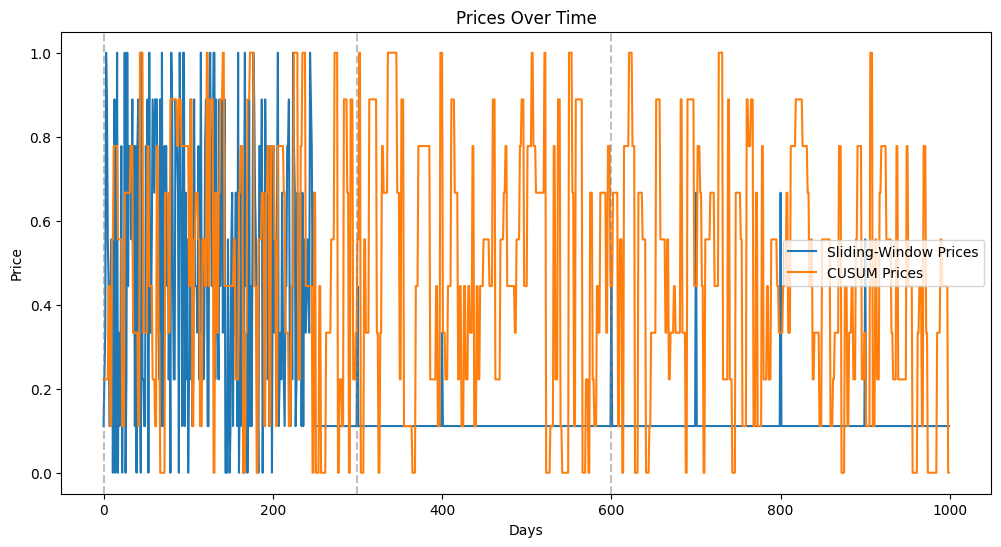

Total revenue for Sliding-Window strategy: 9843.46805592024
Total revenue for CUSUM strategy: 15628.244807136212


In [11]:

#Simlation of the interaction
def run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift):
    environment = NonStationaryPricingEnvironment(num_days, price_levels, intervals)
    sliding_window_strategy = SlidingWindowPricing(price_levels, window_size)
    cusum_strategy = CUSUMPricing(price_levels, cusum_threshold, cusum_drift)

    sliding_window_prices = []
    cusum_prices = []

    sliding_window_revenue = 0
    cusum_revenue = 0

    for day in range(num_days):
        # Update with Sliding-Window
        sliding_price = sliding_window_strategy.get_optimal_price(day)
        sliding_demand = environment.get_demand(day, sliding_price)
        sliding_window_strategy.update_history(sliding_price, sliding_demand)
        sliding_window_prices.append(sliding_price)
        sliding_window_revenue += sliding_price * sliding_demand

        # Update with CUSUM
        cusum_price = cusum_strategy.get_optimal_price()
        cusum_demand = environment.get_demand(day, cusum_price)
        cusum_strategy.update_history(cusum_price, cusum_demand)
        cusum_prices.append(cusum_price)
        cusum_revenue += cusum_price * cusum_demand

    return sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue

# Parameters
num_days = 1000
price_levels = np.linspace(0, 1, 10)
intervals = [(0, 300), (300, 600), (600, 1000)]
window_size = 50
cusum_threshold = 0.5
cusum_drift = 0.1

# Simulation
sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue = run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift)

# We print the results
plt.figure(figsize=(12, 6))
plt.plot(sliding_window_prices, label='Sliding-Window Prices')
plt.plot(cusum_prices, label='CUSUM Prices')
for interval in intervals:
    plt.axvline(x=interval[0], color='gray', linestyle='--', alpha=0.5)
plt.title('Prices Over Time')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display of total rewards
print(f"Total revenue for Sliding-Window strategy: {sliding_window_revenue}")
print(f"Total revenue for CUSUM strategy: {cusum_revenue}")
